In [1]:
import sys
sys.path.insert(1, '/afs/hep.wisc.edu/home/kkboone/software/StarWeights/StellarStreams')

import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import Config
import BalrogTestConfig as balrConfig
matplotlib.style.use('des_dr1')

In [2]:
cutOffPercent = .01
res = 4096
binNum = 10

In [3]:
allPixFile = balrConfig.test1AllPixFile
starFile = balrConfig.test1StarFile
validPixFile = balrConfig.test1ValidPixFile
condFiles = balrConfig.test1CondFiles

In [4]:
injData = fitsio.read(allPixFile)

In [5]:
injPix = hp.ang2pix(res, injData['RA'], injData['DEC'], nest = True, lonlat = True)
validPix = np.unique(injPix)

In [6]:
detData = fitsio.read(starFile)

In [7]:
detPix = hp.ang2pix(res, detData['RA'], detData['DEC'], nest = True, lonlat = True)

In [8]:
_, origDetPixCounts = np.unique(np.append(validPix, detPix), return_counts = True)
origDetPixCounts = origDetPixCounts - 1

In [9]:
condFiles = balrConfig.test1CondFiles

condMaps = []

# This loops over every condition file
for condFile in condFiles:
    condData = fitsio.read(condFile) # This reads in the data
    condMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

condMaps = np.array(condMaps)

In [10]:
aveDet = np.sum(origDetPixCounts) / len(origDetPixCounts)

In [11]:
errorsFile = balrConfig.test1Dir + '80_Test_Errors_' + str(cutOffPercent) + '.fits'
detPixFile = balrConfig.test1Dir + '80_Test_Pix_Counts_' + str(cutOffPercent) + '.fits'
trainIndsFile = balrConfig.test1Dir + '80_Test_Train_Inds_' + str(cutOffPercent) + '.fits'

In [12]:
allErrors = fitsio.read(errorsFile)['Errors']
detPixCounts = fitsio.read(detPixFile)['Counts']
trainInds = fitsio.read(trainIndsFile)['Inds']

In [13]:
conditions = Config.conditions

# 1D Plots

In [14]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

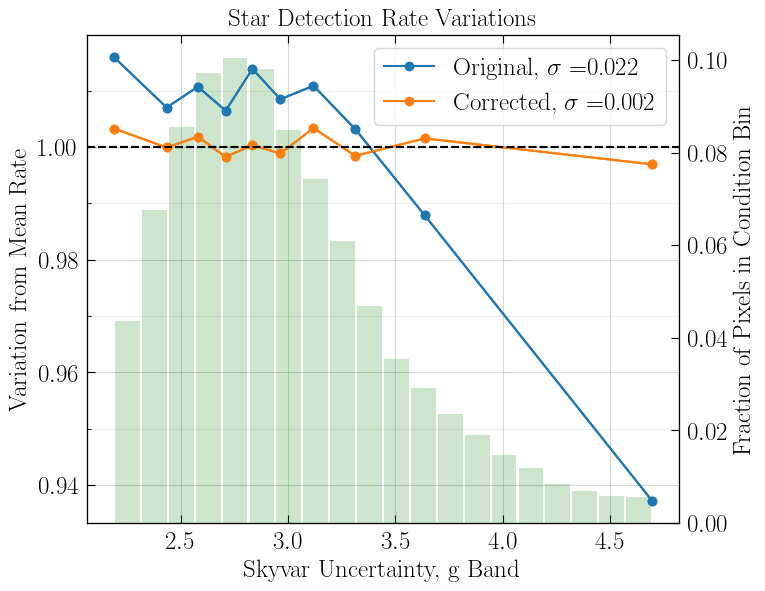

In [20]:
condMaxErrors = []

for condInd in [75]:#range(len(conditions)):
    
    condition = conditions[condInd]
    
    condMap = condMaps[condInd]
    condSortInds = condMap[~trainInds].argsort()
    
    condSort = condMap[~trainInds][condSortInds[::1]]
    detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]
    origDetStarTemp = origDetPixCounts[~trainInds][condSortInds[::1]]

    origDetBins = []
    detBins = []
    condBins = []

    for j in range(10):
        origDetBins.append(origDetStarTemp[binIndLims[j]:binIndLims[j+1]])
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        condBins.append(condSort[binIndLims[j]:binIndLims[j+1]])

    yBinCondOrig = []
    yBinCond = []
    xBinCond = []

    for j in range(10):
        yBinCondOrig.append(np.sum(origDetBins[j]) / (aveDet * len(origDetBins[j])))
        yBinCond.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
        xBinCond.append(np.sum(condBins[j]) / len(condBins[j]))

    xBinCond = np.array(xBinCond)
    yBinCond = np.array(yBinCond)
    yBinCondOrig = np.array(yBinCondOrig)
    
    condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
    
    fig, ax1 = plt.subplots()

    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(0, 2, 0.02)
    minor_ticks = np.arange(0, 2, 0.01)

    ax1.set_yticks(major_ticks)
    ax1.set_yticks(minor_ticks, minor=True)

    ax1.set_xlabel(condition)
    ax1.tick_params(axis='y')
    ax1.set_ylabel(r'Variation from Mean Rate')
    ax1.plot(xBinCond, yBinCondOrig, label = 'Original, ' + r'$\sigma = $' + str(np.round(np.std(yBinCondOrig), decimals = 3)), marker = 'o')
    ax1.plot(xBinCond, yBinCond, label = 'Corrected, ' + r'$\sigma = $' + str(np.round(np.std(yBinCond), decimals = 3)), marker = 'o')
    ax1.axhline(y = 1, color = 'black', linestyle = '--')
    # And a corresponding grid
    ax1.grid(which='both')

    # Or if you want different settings for the grids:
    ax1.grid(which='minor', alpha=0.2)
    ax1.grid(which='major', alpha=0.5)
    # ax1.grid()
    ax1.legend()#loc = 'upper left')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.tick_params(axis='y')
    ax2.set_ylabel('Fraction of Pixels in Condition Bin')
    ax2.hist(condSort, bins = np.linspace(np.min(xBinCond), np.max(xBinCond), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condSort)) / len(condSort))

    ax3 = ax1.twinx()
    ax3.tick_params(axis='y', right = False, labelright = False)
    ax3.plot(xBinCond, yBinCondOrig, marker = 'o')
    ax3.plot(xBinCond, yBinCond, marker = 'o')
    ax3.axhline(y = 1, color = 'black', linestyle = '--')


    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('Star Detection Rate Variations')
    # plt.show()
    plt.savefig('Good Star Detection')

In [16]:
np.average(condMaxErrors)

0.008325819842499972

In [17]:
conditions[np.where(condMaxErrors == np.max(condMaxErrors))[0][0]]

'Teff Minimum, i Band'

In [18]:
np.where(condMaxErrors == np.max(condMaxErrors))[0][0]

46